# Sistemas Lineales - Fourier Pasa Bajas<a class="tocSkip">
## TRATAMIENTO DE SEÑALES <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Suavizado de la imagen usando filtros en el dominio de la frecuencia

Empezamos con los filtros **pasabajos**. Los bordes y otras transiciones abruptas de intensidad (como el ruido) en una imagen contribuyen de gran manera al contenido en alta frecuencia en su rtansformada de Fourier. Por ello, el *smoothing* (blurring) se consigue en el dominio de la frecuencia al atenuar las altas frecuencias.

## Filtro pasabajas ideal (step)
Un filtro ideal pasabajas 2D que pase sin atenuar todas las frecuencias dentro de un circulo con radio $D_0$ del origen, y que corte todas las frecuencias fuera de este círculo es llamado como *filtro pasabajos ideal* (step/delta), y está especificado por la función:
$$
H(u, v) = 
\begin{cases}
    1, & \text{if} \; D(u, v) \leq D_0\\
    0, & \text{if} \; D(u, v) > D_0
\end{cases}
$$ 

En donde $D_0$ es una constante positiva y $D(u, v)$ es la distancia entre el punto $(u, v)$ en el dominio de la frecuencia, y el centro de la imagen en frecuencia



















### implementación del filtro pasabajos ideal

In [1]:
#cargamos las librerias 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def rgb2gray(image):
    """función para convertir una imagen de 3 canales (rgb) a escala de grises (1 canal)"""
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

def showImage(image, title):
    """función para mostrar las imágenes"""
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def showImage2(f, g, titlef, titleg):
    """función para mostrar 2 imágenes con subplot"""
    plt.figure()

    plt.subplot(121)
    plt.imshow(f, cmap='gray')
    plt.title(titlef)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(g, cmap='gray')
    plt.title(titleg)

    plt.axis('off')
    plt.show()

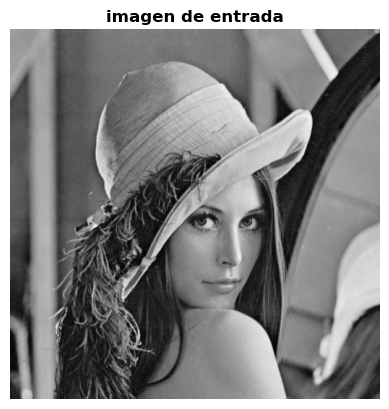

In [3]:
f = mpimg.imread('Lenna.png')
f = rgb2gray(f)

showImage(f, 'imagen de entrada')


obtenemos la transformada de Fourier de esta imagen y centramos el componente de dc.

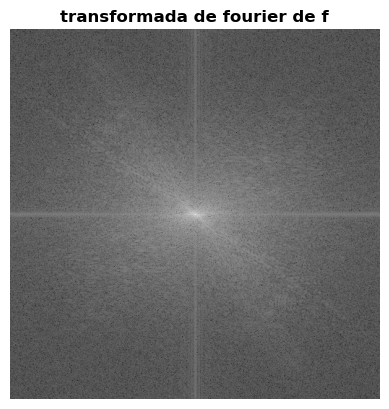

In [4]:
fourier = np.fft.fft2(f) #transformada de fourier
fourier = np.fft.fftshift(fourier) #centrar el componente dc de frecuencia

#mostramos solo la parte real, y aplicamos la transformada logaritmo para poder contraer el contraste de la imagen
showImage(np.real(np.log(1 + fourier)), 'transformada de fourier de f')




Ahora generamos el filtro, el cual será un cículo con un radio $D$ donde los valores que tengan una distancia menor a $D$ valdrán 1 y 0 en caso contrario.

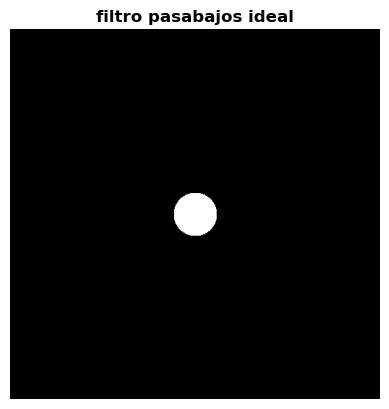

In [5]:
pasabajos_ideal = np.zeros(fourier.shape)
sizeX, sizeY = pasabajos_ideal.shape
D = 30 #radio del circulo

for i in range(sizeX):
    for j in range(sizeY):
        if((i - sizeX//2)**2 + (j - sizeY//2)**2) < D**2:
            #solo a aquellas posiciones que estén dentro del circulo valdrán 1
            pasabajos_ideal[i, j] = 1

showImage(pasabajos_ideal, 'filtro pasabajos ideal')


Ya que tenemos nuestro filtro, procedemos a multiplicarlo con la DFT de la imagen de entrada:
$$H(u, v)F(u, v)$$

A continuación observamos este proceso, y aplicamos la transformada inversa de Fourier para regresar la imagen al dominio espacial una vez filtrada en frecuencia.

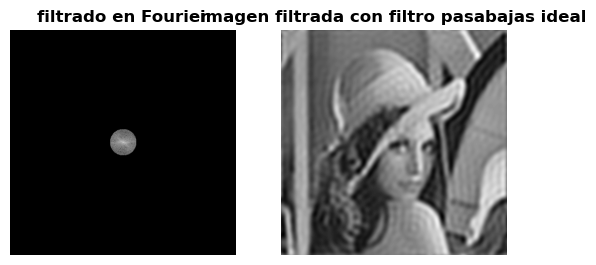

In [6]:
pasabajos_ideal = pasabajos_ideal * fourier

g_ideal = np.fft.ifftshift(pasabajos_ideal) #dado que desfasamos la dft original, vamos a regresar el componente de dc a la cordenada 0,0
g_ideal = np.fft.ifft2(g_ideal) #transformada inversa de Fourier.

showImage2(np.real(np.log(1 + pasabajos_ideal)), np.real(g_ideal), 'filtrado en Fourier', 'imagen filtrada con filtro pasabajas ideal')

Como podemos observar, este tipo de filtro no es muy práctico, a continuación veremos unos más eficientes.

## Filtro butterworth

La función de transferencia de un filtro pasabajos butterworth de orden $n$, y con una frecuencia de corte a una distancia $D_0$ del origen está definido como:

$$ H(u, v) = \frac{1}{1 + [D(u, v)/D_0]^{2n}}$$

En donde $D(u, v)$ es la distancia del centro de la DFT (componente dc) respecto a la posición $(u, v)$:

$$D(u, v) = [(u - M/2)^2 + (v - N/2)^2]^{1/2}$$


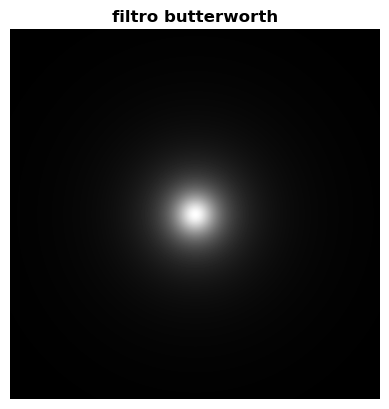

In [7]:
butterworth = np.zeros(f.shape)
D0 = 30
n = 2 * 1

for i in range(sizeX):
    for j in range(sizeY):
        Duv = ((i - sizeX//2)**2 + (j - sizeY//2)**2)**0.5 
        butterworth[i, j] = 1/(1 + (Duv/D0)**(n))

showImage(butterworth, 'filtro butterworth')


Aplicamos el filtro a la imagen en el dominio de la frecuencia.

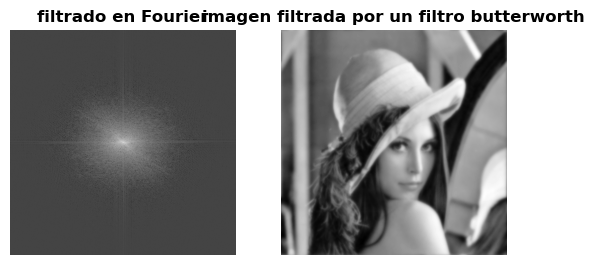

In [8]:
g_filtered_bw1 = butterworth * fourier

g_filtered_bw = np.fft.ifftshift(g_filtered_bw1)
g_filtered_bw = np.fft.ifft2(g_filtered_bw)
g_filtered_bw = np.real(g_filtered_bw)

showImage2(np.real(np.log(1 + g_filtered_bw1)), g_filtered_bw, 'filtrado en Fourier', 'imagen filtrada por un filtro butterworth')


A diferencia del filtro pasabajos ideal, la función de transferencia Butterworth no tiene discontinuidades abruptas que delimita una frecuencias de corte exacta entre las frecuencias que pasan y las que no.

## Filtro pasabajos gaussiano
Los filtros pasabajos gaussianos, en una dimensión el valor de $\sigma$ es una medida de variación alrededor del centro, por lo que haremos $\sigma = D_0$:

$$ H(u, v) = e^{-D^2(u, v)/2 D_0^2} $$

En donde $D_0$ es la frecuencia de corte. A continuación la implementación.
 

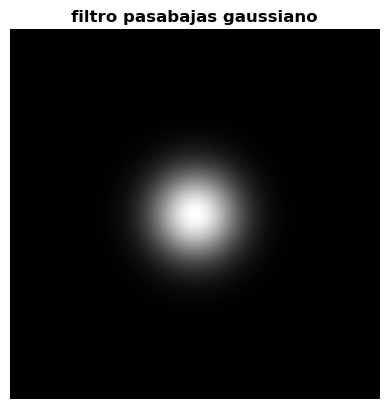

In [9]:
gaussian = np.zeros(f.shape)
D0 = (2 * 30)**2  #frecuencia de corte, el 2 es para no multiplicarlo en cada iteración, seggún la formula

for i in range(sizeX):
    for j in range(sizeY):
        Duv = ((i - sizeX//2)**2 + (j - sizeY//2)**2)
        gaussian[i, j] = np.exp(-1*Duv/D0)

showImage(gaussian, 'filtro pasabajas gaussiano')




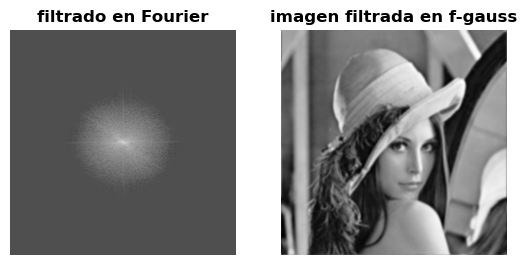

In [10]:
filtrado_gaussiano = gaussian*fourier
g_filtered_gauss = np.fft.ifftshift(filtrado_gaussiano)
g_filtered_gauss = np.fft.ifft2(g_filtered_gauss)
g_filtered_gauss = np.real(g_filtered_gauss)

showImage2(np.real(np.log(1 + filtrado_gaussiano)), g_filtered_gauss, 'filtrado en Fourier', 'imagen filtrada en f-gauss')


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).